## MonReader

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

* Data Description:
    The dataset was collected from page flipping video from smart phones and they was labelled as flipping and not flipping. The videos were clipped as short videos and was labelled as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

* Goal:
    The goal is to Predict if a page is being flipped or Not using a single image.


In [1]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import seaborn as sns
import cv2
from sklearn.metrics import classification_report, confusion_matrix,precision_score,recall_score,accuracy_score,f1_score
import tensorflow as tf

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,Rescaling, GlobalAveragePooling2D,Dropout,LeakyReLU,Flatten,AveragePooling2D, BatchNormalization,Conv2D,MaxPooling2D, TimeDistributed, GRU, LSTM
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

## Data Preprocessing

In [3]:
train_dir = "../input/images/images/training"
test_dir = "../input/images/images/testing"

batch_size = 32
img_height = 200
img_width = 200

train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.
Found 597 files belonging to 2 classes.


In [4]:
class_names = train_dataset.class_names
print(class_names)

['flip', 'notflip']


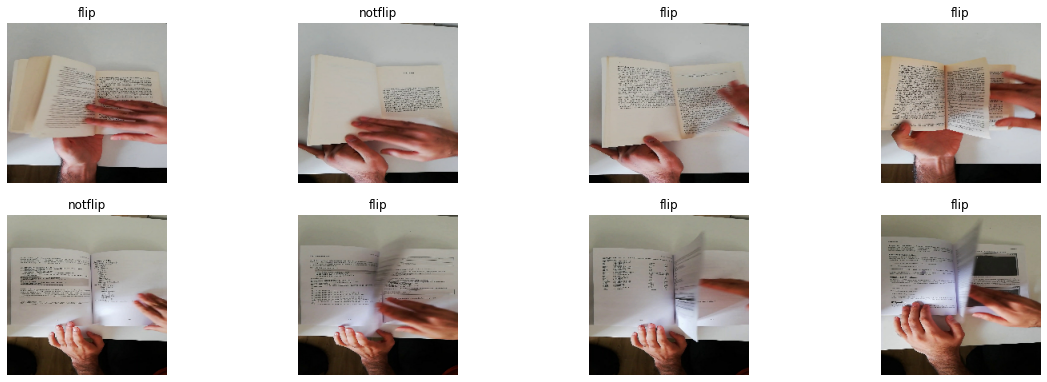

In [5]:
plt.figure(figsize=(20, 10))
for images, labels in train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# data Augmentation

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

## ResNet50 Model 

In [9]:

input_shape = (img_height, img_width, 3)
base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False
base_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
__________________________

In [10]:

# construct the head of the model that will be placed on top.....
inputs = tf.keras.Input(shape=(200, 200, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
head_model = x
head_model = GlobalAveragePooling2D()(head_model)
head_model = BatchNormalization()(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(32, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(16, activation="relu")(head_model)
head_model = Dense(1, activation='sigmoid')(head_model)

model = Model(inputs=inputs, outputs=head_model)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 200, 200, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192  

In [11]:
# Compiling the model
base_learning_rate = 0.001

model.compile(Adam(learning_rate=base_learning_rate, decay=0.01), loss='binary_crossentropy', metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

# save the model with least validation loss
filepath="resnet50_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# callback_list 
callback_list = [checkpoint, earlystopping]


In [12]:
initial_epochs = 30

history = model.fit(train_dataset, 
                    epochs = initial_epochs,
                    validation_data = val_dataset,
                    callbacks = callback_list,
                    verbose = 1)

Epoch 1/30
60/60 [==============================] - 39s 455ms/step - loss: 0.6290 - accuracy: 0.6557 - val_loss: 0.6114 - val_accuracy: 0.5753

Epoch 00001: val_accuracy improved from -inf to 0.57531, saving model to resnet50_best.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
60/60 [==============================] - 4s 72ms/step - loss: 0.4561 - accuracy: 0.7821 - val_loss: 0.3740 - val_accuracy: 0.8724

Epoch 00002: val_accuracy improved from 0.57531 to 0.87238, saving model to resnet50_best.h5
Epoch 3/30
60/60 [==============================] - 4s 69ms/step - loss: 0.3460 - accuracy: 0.8516 - val_loss: 0.2729 - val_accuracy: 0.9100

Epoch 00003: val_accuracy improved from 0.87238 to 0.91004, saving model to resnet50_best.h5
Epoch 4/30
60/60 [==============================] - 4s 69ms/step - loss: 0.2951 - accuracy: 0.8788 - val_loss: 0.2192 - val_accuracy: 0.9163

Epoch 00004: val_accuracy improved from 0.91004 to 0.91632, saving model to resnet50_best.h5
Epoch 5/30
60/60 [==============================] - 4s 70ms/step - loss: 0.2649 - accuracy: 0.8898 - val_loss: 0.1925 - val_accuracy: 0.9351

Epoch 00005: val_accuracy improved from 0.91632 to 0.93515, saving model to resnet50_best.h5
Epoch 6/30
60/60 [==============================] - 4s 69ms/

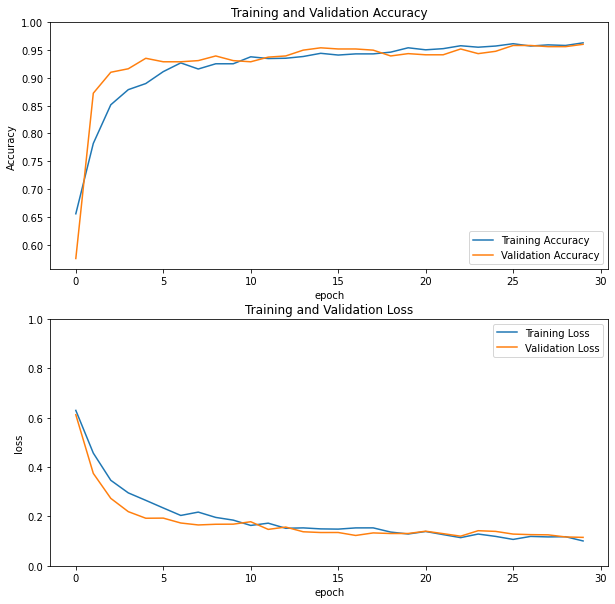

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
test_score = model.evaluate(test_dataset)
print("")
print(" Accuracy: {:.2f}%".format(test_score[1] * 100)) 
print(" Loss: ",test_score[0])

19/19 [==============================] - 7s 231ms/step - loss: 0.0598 - accuracy: 0.9816

 Accuracy: 98.16%
 Loss:  0.059791866689920425


In [15]:
y_pred = model.predict(test_dataset)

In [16]:
y_true = tf.concat([y for x, y in test_dataset], axis=0)

In [17]:
print(classification_report(y_true,tf.round(y_pred)))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       290
           1       0.98      0.98      0.98       307

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



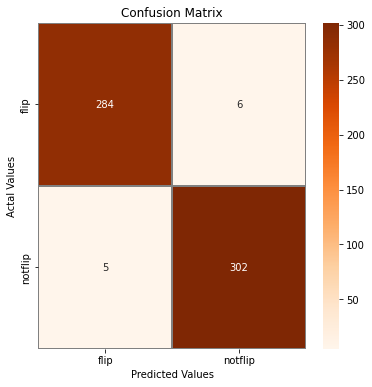

In [18]:
cm = confusion_matrix(y_true,tf.round(y_pred))
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True,linewidths=0.01,cmap="Oranges", linecolor="gray",fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [19]:
print(" F1_score: ",f1_score(y_true,tf.round(y_pred))*100)

 F1_score:  98.21138211382113


In [20]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true, tf.round(y_pred))
    roc_auc[i] = auc(fpr[i], tpr[i])

print(" ROC_AUC_Score: ",roc_auc_score(y_true, tf.round(y_pred)))

 ROC_AUC_Score:  0.9815118499382229


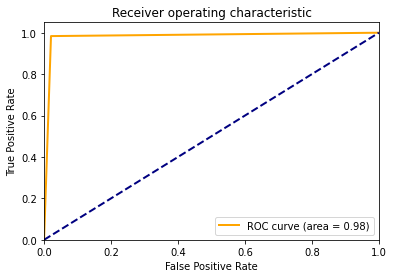

In [21]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="orange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

### Vgg16 Model

In [22]:
input_shape = (img_height, img_width, 3)
vgg_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
vgg_model.trainable = False
# Let's take a look at the base model architecture
vgg_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
______________________________________________________________

In [23]:

# construct the head of the model that will be placed on top.....
inputs = tf.keras.Input(shape=(200, 200, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)
head_model = x
head_model = GlobalAveragePooling2D()(head_model)
head_model = BatchNormalization()(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(32, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(16, activation="relu")(head_model)
head_model = Dense(1, activation='sigmoid')(head_model)

model = Model(inputs=inputs, outputs=head_model)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 200, 200, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 200, 200, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048

In [24]:
# Compiling the model
base_learning_rate = 0.001

model.compile(Adam(learning_rate=base_learning_rate, decay=0.01), loss='binary_crossentropy', metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

# save the model with least validation loss
filepath="vgg_model_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# callback_list 
callback_list = [checkpoint, earlystopping]

In [25]:
initial_epochs = 30

history = model.fit(train_dataset, 
                    epochs = initial_epochs,
                    validation_data = val_dataset,
                    callbacks = callback_list,
                    verbose = 1)

Epoch 1/30
60/60 [==============================] - 12s 146ms/step - loss: 0.6753 - accuracy: 0.5726 - val_loss: 0.5905 - val_accuracy: 0.6841

Epoch 00001: val_accuracy improved from -inf to 0.68410, saving model to vgg_model_best.h5
Epoch 2/30
60/60 [==============================] - 4s 69ms/step - loss: 0.5658 - accuracy: 0.6897 - val_loss: 0.4681 - val_accuracy: 0.7762

Epoch 00002: val_accuracy improved from 0.68410 to 0.77615, saving model to vgg_model_best.h5
Epoch 3/30
60/60 [==============================] - 4s 70ms/step - loss: 0.4694 - accuracy: 0.7900 - val_loss: 0.3930 - val_accuracy: 0.8075

Epoch 00003: val_accuracy improved from 0.77615 to 0.80753, saving model to vgg_model_best.h5
Epoch 4/30
60/60 [==============================] - 4s 69ms/step - loss: 0.3939 - accuracy: 0.8344 - val_loss: 0.3164 - val_accuracy: 0.8515

Epoch 00004: val_accuracy improved from 0.80753 to 0.85146, saving model to vgg_model_best.h5
Epoch 5/30
60/60 [==============================] - 4s 71

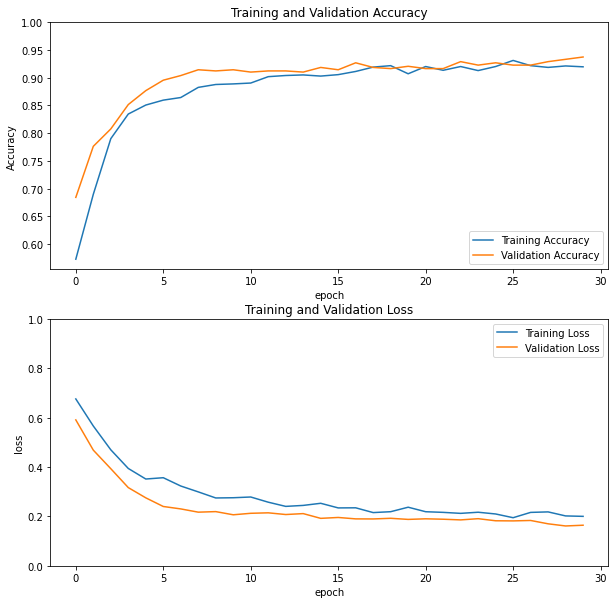

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
test_score = model.evaluate(test_dataset)
print("")
print(" Accuracy: {:.2f}%".format(test_score[1] * 100)) 
print(" Loss: ",test_score[0])

19/19 [==============================] - 3s 144ms/step - loss: 0.1787 - accuracy: 0.9347

 Accuracy: 93.47%
 Loss:  0.17868965864181519


In [28]:
y_pred = model.predict(test_dataset)

In [29]:
y_true = tf.concat([y for x, y in test_dataset], axis=0)

In [30]:
print(classification_report(y_true,tf.round(y_pred)))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       290
           1       0.94      0.93      0.94       307

    accuracy                           0.93       597
   macro avg       0.93      0.93      0.93       597
weighted avg       0.93      0.93      0.93       597



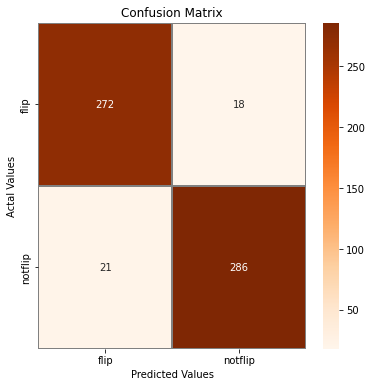

In [31]:
cm = confusion_matrix(y_true,tf.round(y_pred))
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True,linewidths=0.01,cmap="Oranges", linecolor="gray",fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [32]:
print(" F1_score: ",f1_score(y_true,tf.round(y_pred))*100)

 F1_score:  93.61702127659575


In [33]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true, tf.round(y_pred))
    roc_auc[i] = auc(fpr[i], tpr[i])

print(" ROC_AUC_Score: ",roc_auc_score(y_true, tf.round(y_pred)))

 ROC_AUC_Score:  0.9347635628439851


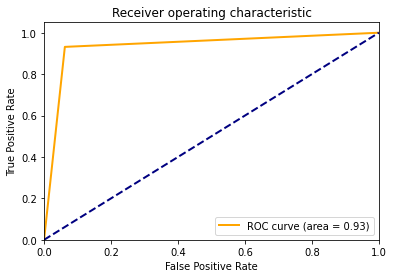

In [34]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="orange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# EfficientNet Creation

In [35]:
input_shape = (img_height, img_width, 3)
eff_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
eff_model.trainable = False
# Let's take a look at the base model architecture
eff_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 200, 200, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 200, 200, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 201, 201, 3)  0           normalization[0][0]              
____________________

In [36]:

# construct the head of the model that will be placed on top.....
inputs = tf.keras.Input(shape=(200, 200, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = eff_model(x)
head_model = x
head_model = GlobalAveragePooling2D()(head_model)
head_model = BatchNormalization()(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(32, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(16, activation="relu")(head_model)
head_model = Dense(1, activation='sigmoid')(head_model)

model = Model(inputs=inputs, outputs=head_model)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0   

In [37]:
# Compiling the model
base_learning_rate = 0.001

model.compile(Adam(learning_rate=base_learning_rate, decay=0.01), loss='binary_crossentropy', metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

# save the model with least validation loss
filepath="eff_model_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# callback_list 
callback_list = [checkpoint, earlystopping]

In [38]:
#model training
initial_epochs = 30

history = model.fit(train_dataset, 
                    epochs = initial_epochs,
                    validation_data = val_dataset,
                    callbacks = callback_list,
                    verbose = 1)

Epoch 1/30
60/60 [==============================] - 10s 73ms/step - loss: 0.6559 - accuracy: 0.6170 - val_loss: 0.6055 - val_accuracy: 0.7741

Epoch 00001: val_accuracy improved from -inf to 0.77406, saving model to eff_model_best.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
60/60 [==============================] - 3s 45ms/step - loss: 0.5353 - accuracy: 0.7409 - val_loss: 0.5143 - val_accuracy: 0.8828

Epoch 00002: val_accuracy improved from 0.77406 to 0.88285, saving model to eff_model_best.h5
Epoch 3/30
60/60 [==============================] - 3s 46ms/step - loss: 0.4360 - accuracy: 0.8109 - val_loss: 0.3927 - val_accuracy: 0.8891

Epoch 00003: val_accuracy improved from 0.88285 to 0.88912, saving model to eff_model_best.h5
Epoch 4/30
60/60 [==============================] - 3s 45ms/step - loss: 0.3910 - accuracy: 0.8292 - val_loss: 0.3122 - val_accuracy: 0.9372

Epoch 00004: val_accuracy improved from 0.88912 to 0.93724, saving model to eff_model_best.h5
Epoch 5/30
60/60 [==============================] - 3s 45ms/step - loss: 0.3387 - accuracy: 0.8412 - val_loss: 0.2563 - val_accuracy: 0.9163

Epoch 00005: val_accuracy did not improve from 0.93724
Epoch 6/30
60/60 [==============================] - 3s 45ms/step - loss: 0.3174 - accuracy: 0.8

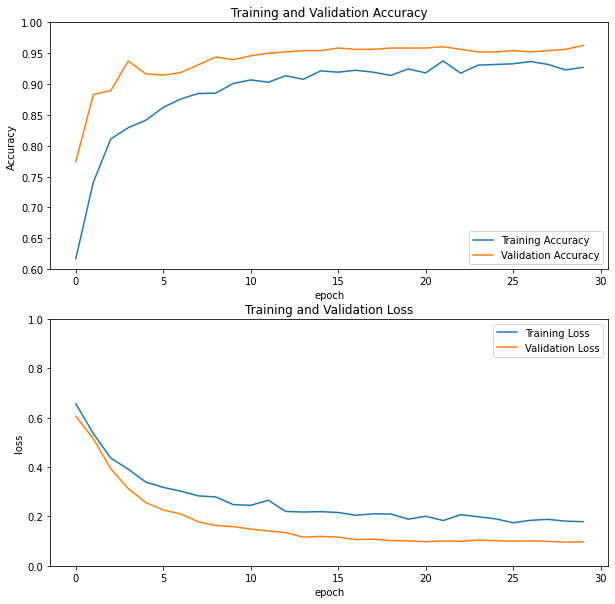

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
test_score = model.evaluate(test_dataset)
print("")
print(" Accuracy: {:.2f}%".format(test_score[1] * 100)) 
print(" Loss: ",test_score[0])

19/19 [==============================] - 1s 43ms/step - loss: 0.0774 - accuracy: 0.9715

 Accuracy: 97.15%
 Loss:  0.07744647562503815


In [41]:
y_pred = model.predict(test_dataset)

In [42]:
y_true = tf.concat([y for x, y in test_dataset], axis=0)

In [43]:
print(classification_report(y_true,tf.round(y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       290
           1       0.96      0.99      0.97       307

    accuracy                           0.97       597
   macro avg       0.97      0.97      0.97       597
weighted avg       0.97      0.97      0.97       597



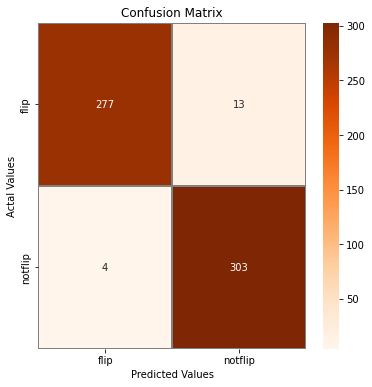

In [44]:
cm = confusion_matrix(y_true,tf.round(y_pred))
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True,linewidths=0.01,cmap="Oranges", linecolor="gray",fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [45]:
print(" F1_score: ",f1_score(y_true,tf.round(y_pred))*100)

 F1_score:  97.27126805778492


In [46]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true, tf.round(y_pred))
    roc_auc[i] = auc(fpr[i], tpr[i])

print(" ROC_AUC_Score: ",roc_auc_score(y_true, tf.round(y_pred)))

 ROC_AUC_Score:  0.9710715489160957


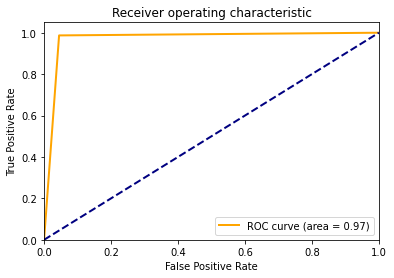

In [47]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="orange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

### CNN Model

In [48]:
#create model
cnn_model = Sequential()
#add model layers
cnn_model.add(Rescaling(1./255, input_shape=input_shape))
cnn_model.add(Conv2D(16, kernel_size=3, padding="same", activation="relu", input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
cnn_model.add(Conv2D(32, kernel_size=3, padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(32, activation="relu"))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(16, activation="relu"))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(1, activation="sigmoid"))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 66, 66, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 66, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

In [49]:
# Compiling the model
base_learning_rate = 0.001

cnn_model.compile(Adam(learning_rate=base_learning_rate, decay=0.01), loss='binary_crossentropy', metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)

# save the model with least validation loss
filepath="cnn_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# callback_list 
callback_list = [checkpoint, earlystopping]

In [50]:
#Model Training
initial_epochs = 30

history = cnn_model.fit(train_dataset, 
                    epochs = initial_epochs,
                    validation_data = val_dataset,
                    callbacks = callback_list,
                    verbose = 1)

Epoch 1/30
60/60 [==============================] - 3s 19ms/step - loss: 0.7066 - accuracy: 0.5329 - val_loss: 0.6915 - val_accuracy: 0.5732

Epoch 00001: val_accuracy improved from -inf to 0.57322, saving model to cnn_best.h5
Epoch 2/30
60/60 [==============================] - 1s 15ms/step - loss: 0.6882 - accuracy: 0.5413 - val_loss: 0.6761 - val_accuracy: 0.5983

Epoch 00002: val_accuracy improved from 0.57322 to 0.59833, saving model to cnn_best.h5
Epoch 3/30
60/60 [==============================] - 1s 14ms/step - loss: 0.6740 - accuracy: 0.5742 - val_loss: 0.6531 - val_accuracy: 0.6778

Epoch 00003: val_accuracy improved from 0.59833 to 0.67782, saving model to cnn_best.h5
Epoch 4/30
60/60 [==============================] - 1s 14ms/step - loss: 0.6401 - accuracy: 0.6411 - val_loss: 0.6135 - val_accuracy: 0.6632

Epoch 00004: val_accuracy did not improve from 0.67782
Epoch 5/30
60/60 [==============================] - 1s 15ms/step - loss: 0.5981 - accuracy: 0.6881 - val_loss: 0.534

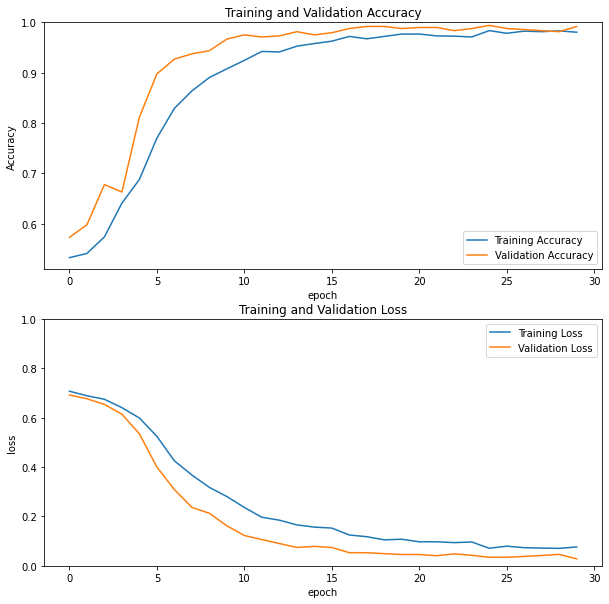

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
test_score = cnn_model.evaluate(test_dataset)
print("")
print(" Accuracy: {:.2f}%".format(test_score[1] * 100)) 
print(" Loss: ",test_score[0])

19/19 [==============================] - 0s 8ms/step - loss: 0.0573 - accuracy: 0.9816

 Accuracy: 98.16%
 Loss:  0.05731535330414772


In [53]:
y_pred = cnn_model.predict(test_dataset)

In [54]:
y_true = tf.concat([y for x, y in test_dataset], axis=0)

In [55]:
print(classification_report(y_true,tf.round(y_pred)))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       290
           1       0.99      0.97      0.98       307

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



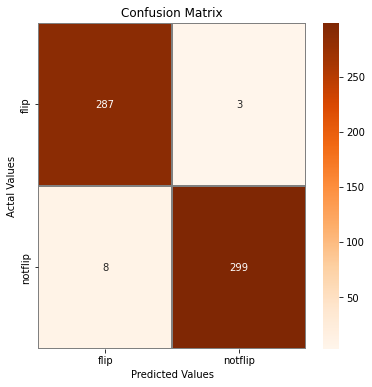

In [56]:
cm = confusion_matrix(y_true,tf.round(y_pred))
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True,linewidths=0.01,cmap="Oranges", linecolor="gray",fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [57]:
# F1 score
print(" F1_score: ",f1_score(y_true,tf.round(y_pred))*100)

 F1_score:  98.19376026272579


In [58]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true, tf.round(y_pred))
    roc_auc[i] = auc(fpr[i], tpr[i])

print(" ROC_AUC_SCORE: ",roc_auc_score(y_true, tf.round(y_pred)))

 ROC_AUC_SCORE:  0.9817982702459845


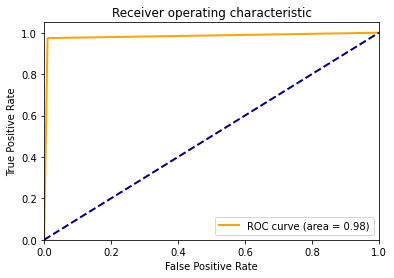

In [59]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="orange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

## Testing on a New Data

In [60]:
new_model = tf.keras.models.load_model('cnn_best.h5')

In [61]:
test_data = tf.keras.utils.image_dataset_from_directory(
  "../input/final-test/Images",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 66 files belonging to 2 classes.


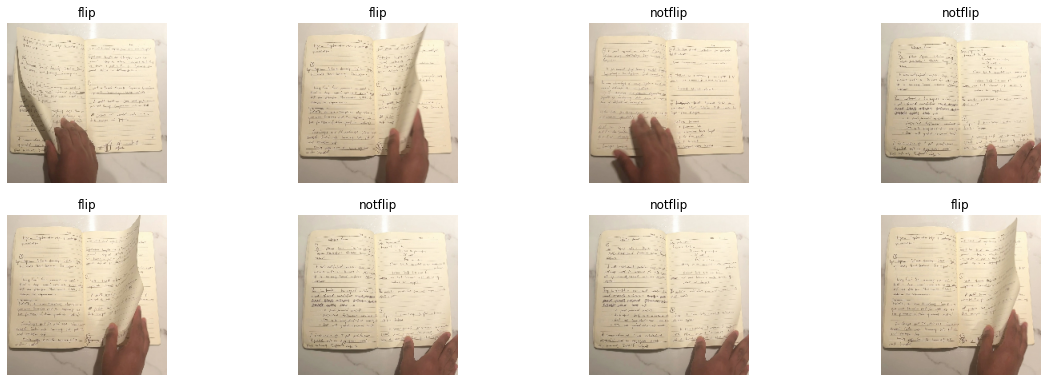

In [62]:
plt.figure(figsize=(20, 10))
for images, labels in test_data.take(1):
  for i in range(8):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [63]:
y_pred = new_model.predict(test_data)

In [64]:
y_true = tf.concat([y for x, y in test_data], axis=0)
print(classification_report(y_true,tf.round(y_pred)))

              precision    recall  f1-score   support

           0       0.71      0.26      0.37        47
           1       0.29      0.74      0.41        19

    accuracy                           0.39        66
   macro avg       0.50      0.50      0.39        66
weighted avg       0.58      0.39      0.39        66



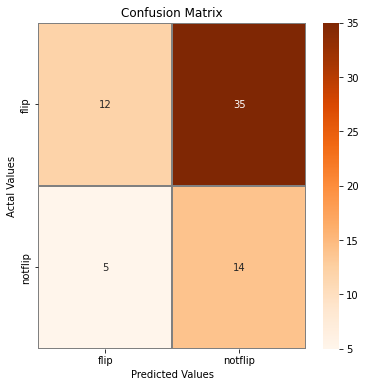

In [65]:
cm = confusion_matrix(y_true,tf.round(y_pred))
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = test_data.class_names, 
                     columns = test_data.class_names)

plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True,linewidths=0.01,cmap="Oranges", linecolor="gray",fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Conclusion


The objective of the project was to work on the page flipping technology and predict from low-resolution images whether the page is being flipped or not. We trained different transfer learning model and a CNN model with the Efficent Model having the highest F1-score of 98%. 